In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/delhi-1-tweets/finaldelhi-1.csv
/kaggle/input/roberta-weights/model.h5


In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

2022-02-15 04:27:51.131978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 35
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 2

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [5]:
df = pd.read_csv('../input/delhi-1-tweets/finaldelhi-1.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df = df.reset_index(drop = True)
df

,id,date,content
0,1366175711854161925,2021-02-28,thankyou understand reply thats solution even ...
1,1366173659925147659,2021-02-28,giveaway time comment tweak need uncover
2,1366172614662651907,2021-02-28,thankyou quick reply little concerned respect ...
3,1366172347414179840,2021-02-28,teri aisi taisi sale
4,1366171685007675392,2021-02-28,आपक लगत पटन
...,...,...,...
1121508,1399519875236655104,2021-06-01,msg cute little girl sir
1121509,1399519587893334018,2021-06-01,agree take science dont treat people free cost...
1121510,1399518396866252803,2021-06-01,posted photo sohum sutra
1121511,1399518311000416256,2021-06-01,well slaughter pig place sokoto soon foolani


In [6]:
from datetime import datetime

def strtodate(text):
    return datetime.strptime(text, '%Y-%m-%d').date()

df['date']=df['date'].apply(strtodate)

In [7]:
df = df.sort_values(by="date")
df = df.drop_duplicates(subset=['date','content'])
df = df.reset_index(drop=True)
df

,id,date,content
0,1345047581118791682,2021-01-01,extended coc officers cop rating
1,1344974890248544258,2021-01-01,आदरण अमरप उनक आपक जनस करत नववर
2,1344974860020195328,2021-01-01,dso official wished customer baba filling stat...
3,1344974843683418112,2021-01-01,difference betweenpakistan india ram mandir fa...
4,1344974821377994752,2021-01-01,aree bhai bhai bhagvan hath diye hai tweet krn...
...,...,...,...
1029267,1410137213447200773,2021-06-30,let start game
1029268,1410137049093472260,2021-06-30,often due lack strong opposition physical ment...
1029269,1410137047331852288,2021-06-30,post political situation country lot politicia...
1029270,1410137039853346816,2021-06-30,see people trivializing ignoring systematic ta...


In [8]:
X_data = df[['content']].to_numpy().reshape(-1)

In [9]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [10]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [12]:
with strategy.scope():
    model = build_model(2)
    model.summary()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

2022-02-15 04:28:37.529674: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-15 04:28:37.533560: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-15 04:28:37.602162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 04:28:37.604506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-02-15 04:28:37.604667: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-15 04:28:37.641496: I tensorflow/stream_executor/platform/def

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [13]:
model.load_weights('../input/roberta-weights/model.h5')

In [14]:
X_train = roberta_encode(X_data, tokenizer)

In [15]:
predictions = model.predict(X_train)
print(predictions)

2022-02-15 04:31:50.928717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-15 04:31:50.938507: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz


[[5.7078159e-01 4.2921841e-01]
 [2.0865491e-08 1.0000000e+00]
 [7.7918461e-03 9.9220818e-01]
 ...
 [1.6320843e-07 9.9999988e-01]
 [2.0534908e-12 1.0000000e+00]
 [6.2648869e-05 9.9993730e-01]]


In [16]:
classes = np.argmax(predictions, axis = 1)
print(classes)

[0 1 1 ... 1 1 1]


In [17]:
df['label']=classes
df

,id,date,content,label
0,1345047581118791682,2021-01-01,extended coc officers cop rating,0
1,1344974890248544258,2021-01-01,आदरण अमरप उनक आपक जनस करत नववर,1
2,1344974860020195328,2021-01-01,dso official wished customer baba filling stat...,1
3,1344974843683418112,2021-01-01,difference betweenpakistan india ram mandir fa...,1
4,1344974821377994752,2021-01-01,aree bhai bhai bhagvan hath diye hai tweet krn...,0
...,...,...,...,...
1029267,1410137213447200773,2021-06-30,let start game,0
1029268,1410137049093472260,2021-06-30,often due lack strong opposition physical ment...,1
1029269,1410137047331852288,2021-06-30,post political situation country lot politicia...,1
1029270,1410137039853346816,2021-06-30,see people trivializing ignoring systematic ta...,1


In [18]:
df.to_csv('Delhi_updated.csv')

In [19]:
df['label'].value_counts()

1    679824
0    349448
Name: label, dtype: int64

In [20]:
x = df.groupby('date') \
       .agg({'content':'size', 'label':'mean'}) \
       .rename(columns={'content':'count','label':'PCI'}) \
       .reset_index()
print (x)

           date  count       PCI
0    2021-01-01   5399  0.660122
1    2021-01-02   4825  0.597098
2    2021-01-03   5826  0.639890
3    2021-01-04   4918  0.639894
4    2021-01-05   5311  0.639992
..          ...    ...       ...
176  2021-06-26   4188  0.617001
177  2021-06-27   4798  0.662568
178  2021-06-28   4844  0.659579
179  2021-06-29   4645  0.625404
180  2021-06-30   4571  0.631153

[181 rows x 3 columns]


In [21]:
x.to_csv('Delhi_PCI.csv')

<AxesSubplot:xlabel='date'>

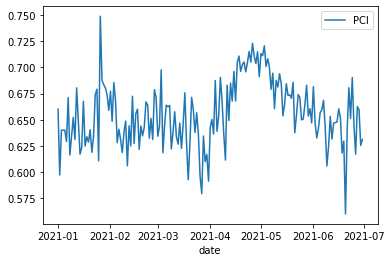

In [22]:
x.plot(x="date", y=["PCI"])